Imports

In [23]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm, poisson

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

Input parameters for scraping

In [24]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [25]:
scrap_games(years)

HTTPError: 429 Client Error: Too Many Requests for url: https://www.basketball-reference.com/leagues/NBA_2023_games.html

Read data

In [ ]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)
print(seasons_games)

{2022:                      start_time              away_team  away_team_score  \
0     2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1     2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2     2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3     2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4     2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   
...                         ...                    ...              ...   
1318  2022-06-06 00:00:00+00:00         BOSTON CELTICS               88   
1319  2022-06-09 01:00:00+00:00  GOLDEN STATE WARRIORS              100   
1320  2022-06-11 01:00:00+00:00  GOLDEN STATE WARRIORS              107   
1321  2022-06-14 01:00:00+00:00         BOSTON CELTICS               94   
1322  2022-06-17 01:00:00+00:00  GOLDEN STATE WARRIORS              103   

                  home_team  home_team_score  
0           MILWAUKEE BUCKS              127 

Edit dataframe

In [ ]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())
print(teams)
# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']


['MILWAUKEE BUCKS', 'LOS ANGELES LAKERS', 'CHARLOTTE HORNETS', 'DETROIT PISTONS', 'NEW YORK KNICKS', 'TORONTO RAPTORS', 'MEMPHIS GRIZZLIES', 'MINNESOTA TIMBERWOLVES', 'NEW ORLEANS PELICANS', 'SAN ANTONIO SPURS', 'UTAH JAZZ', 'PORTLAND TRAIL BLAZERS', 'PHOENIX SUNS', 'ATLANTA HAWKS', 'MIAMI HEAT', 'GOLDEN STATE WARRIORS', 'ORLANDO MAGIC', 'WASHINGTON WIZARDS', 'CLEVELAND CAVALIERS', 'PHILADELPHIA 76ERS', 'BOSTON CELTICS', 'HOUSTON ROCKETS', 'CHICAGO BULLS', 'DENVER NUGGETS', 'SACRAMENTO KINGS', 'INDIANA PACERS', 'LOS ANGELES CLIPPERS', 'BROOKLYN NETS', 'OKLAHOMA CITY THUNDER', 'DALLAS MAVERICKS']


Show data (first 5 rows)

In [ ]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

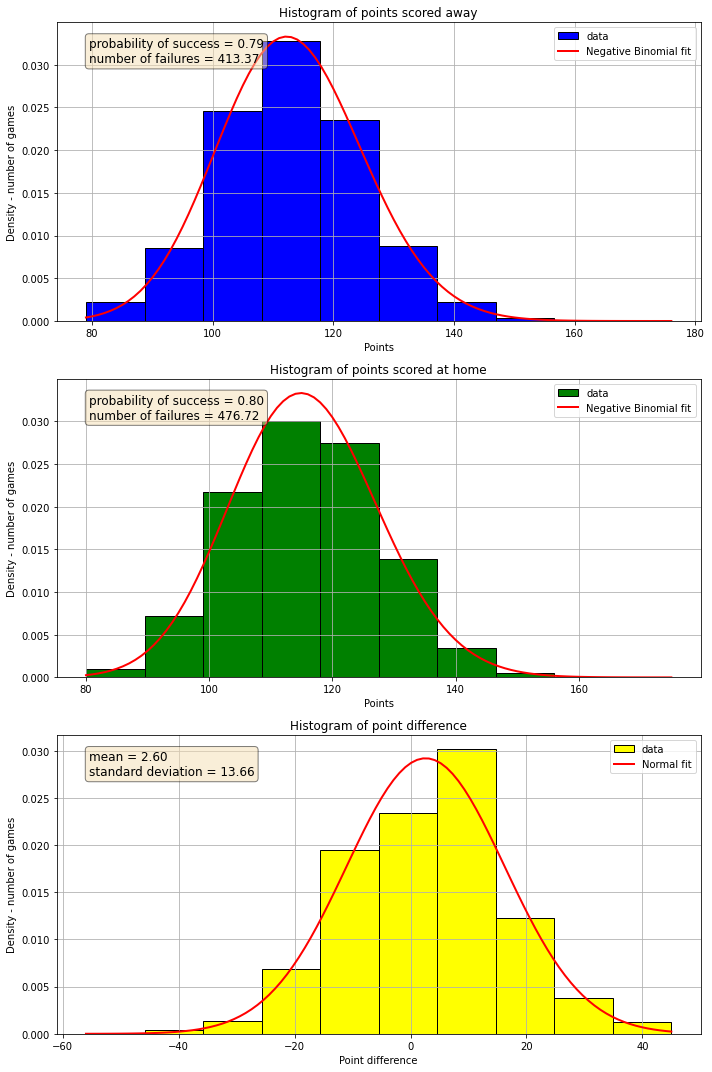

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    if col == 'difference':
        std = np.sqrt(var)
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'probability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [ ]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

Modelling

Model 2 - poisson

Predicting

In [26]:
with open('src/model/model_2.stan', 'r') as f:
    print(f.read())

data {
  int teams_number;
  int games_number;
  array[games_number] int home_team;
  array[games_number] int away_team;
  array[games_number] int<lower=0> home_score;
  array[games_number] int<lower=0> away_score;
}
parameters {
  real mu_home_att;
  real mu_away_att;
  real mu_home_def;
  real mu_away_def;
  real<lower=0> sigma2_att;
  real<lower=0> sigma2_def;

  vector[teams_number-1] home_att_raw;
  vector[teams_number-1] away_att_raw;
  vector[teams_number-1] home_def_raw;
  vector[teams_number-1] away_def_raw;
}
transformed parameters {
  vector[games_number] log_mu_home;
  vector[games_number] log_mu_away;
  vector[teams_number] home_att;
  vector[teams_number] away_att;
  vector[teams_number] home_def;
  vector[teams_number] away_def;

  // need to make sum(att)=sum(def)=0
  for (k in 1:(teams_number-1)) {
    home_att[k] = home_att_raw[k];
    away_att[k] = away_att_raw[k];
    home_def[k] = home_def_raw[k];
    away_def[k] = away_att_raw[k];
  }
  home_att[teams_number] = -s

In [27]:
model_2 = CmdStanModel(stan_file='src/model/model_2.stan')
samples = 1000
sim=model_2.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=False,
                     refresh=samples)

INFO:cmdstanpy:compiling stan file /app/src/model/model_2.stan to exe file /app/src/model/model_2
INFO:cmdstanpy:compiled model executable: /app/src/model/model_2
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [28]:
mod_2 = sim.draws_pd()
mod_2.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_home_att,mu_away_att,mu_home_def,...,away_def[21],away_def[22],away_def[23],away_def[24],away_def[25],away_def[26],away_def[27],away_def[28],away_def[29],away_def[30]
0,-414756.0,0.0,14.3855,0.0,1.0,1.0,414798.0,0.361339,0.340213,0.98062,...,-1.2583,-0.486154,-1.71308,0.062093,1.76841,1.57424,-0.928414,-0.984056,0.408864,-12.9094
1,-414756.0,0.0,14.3855,0.0,1.0,1.0,414816.0,0.361339,0.340213,0.98062,...,-1.2583,-0.486154,-1.71308,0.062093,1.76841,1.57424,-0.928414,-0.984056,0.408864,-12.9094
2,-414756.0,0.0,14.3855,0.0,1.0,1.0,414813.0,0.361339,0.340213,0.98062,...,-1.2583,-0.486154,-1.71308,0.062093,1.76841,1.57424,-0.928414,-0.984056,0.408864,-12.9094
3,-414756.0,0.0,14.3855,0.0,1.0,1.0,414815.0,0.361339,0.340213,0.98062,...,-1.2583,-0.486154,-1.71308,0.062093,1.76841,1.57424,-0.928414,-0.984056,0.408864,-12.9094
4,-414756.0,0.0,14.3855,0.0,1.0,1.0,414819.0,0.361339,0.340213,0.98062,...,-1.2583,-0.486154,-1.71308,0.062093,1.76841,1.57424,-0.928414,-0.984056,0.408864,-12.9094


2023


/tmp/ipykernel_5265/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


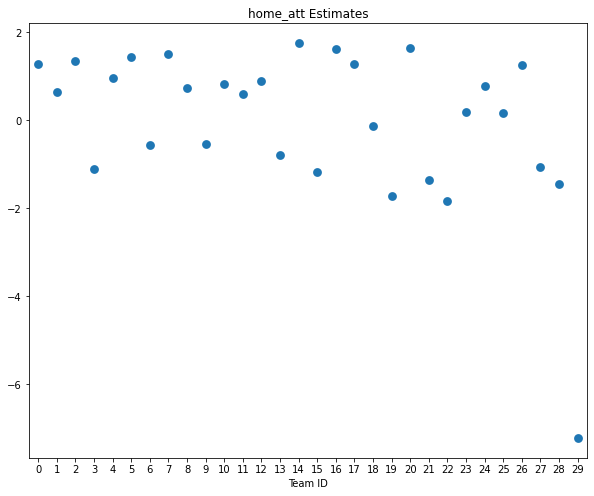

/tmp/ipykernel_5265/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


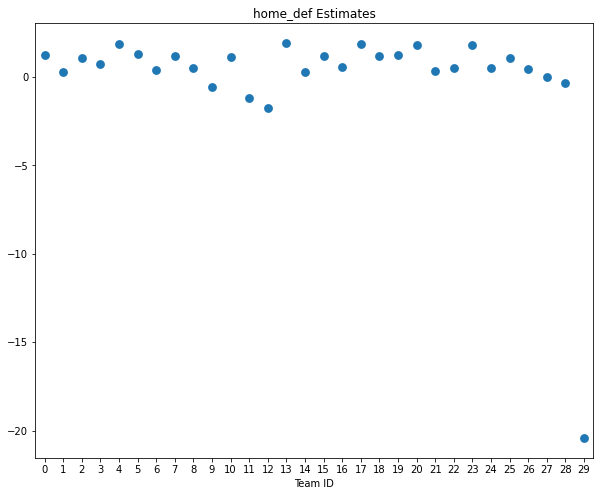

/tmp/ipykernel_5265/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


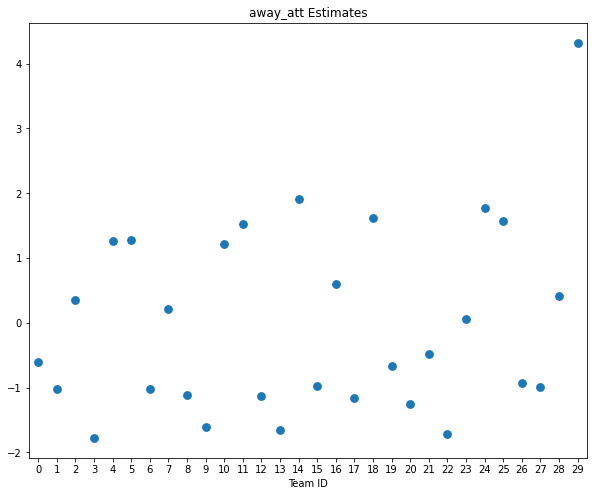

/tmp/ipykernel_5265/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


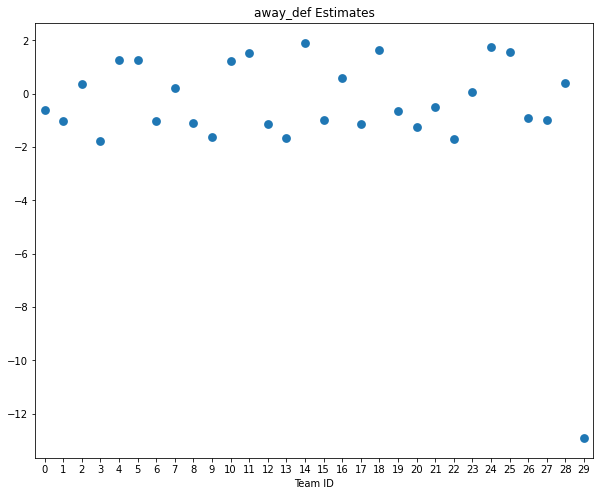

In [29]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
print(year)
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)
    ax.set_xticks(range(len(teams)))
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

In [30]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
param_dict = {param: sim.stan_variable(param) for param in parameters}

# Przykładowe dane do przewidywania (przykładowe ID drużyn)
seasons_games = {
    pred_year: pd.DataFrame({
        'home_team_id': [0, 1, 2],  # Przykładowe ID drużyn domowych
        'away_team_id': [1, 2, 0],   # Przykładowe ID drużyn wyjazdowych
        'home_team_score': [115, 110, 90],
        'away_team_score': [90, 110, 100]
    })
}

# Przewidywanie wyników dla każdego meczu
for idx, row in seasons_games[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    home_score = row['home_team_score']
    away_score = row['away_team_score']
    
    # Pobieranie odpowiednich parametrów dla drużyn
    home_att = param_dict['home_att'][:, home_idx]
    home_def = param_dict['home_def'][:, away_idx]
    away_att = param_dict['away_att'][:, home_idx]
    away_def = param_dict['away_def'][:, away_idx]
    
    # Tworzenie parametrów log_mu
    log_mu1 = home_att + away_def + np.log(home_score)
    log_mu2 = home_def + away_att + np.log(away_score)
    
    # Symulowanie z rozkładu Poissona dla uzyskania predyktywnej dystrybucji
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    print(y1)
    # draw blocked
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    
    # Obliczanie prawdopodobieństw wyników
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [np.mean(y1 > y2)],
        'away_team_win_prob': [np.mean(y1 < y2)]
    })
    
    print(outcome_probabilities)

[153 139 152 158 139 136 139 145 164 152 164 151 128 131 148 134 166 135
 130 170 163 159 136 159 139 153 139 151 163 155 164 147 146 132 156 152
 153 149 140 143 142 133 136 173 168 133 147 163 157 130 141 161 157 148
 155 162 151 161 135 160 163 162 147 153 152 153 146 168 174 155 148 157
 142 143 151 147 167 125 175 174 132 151 133 148 166 150 148 139 175 147
 152 168 164 120 148 158 153 146 151 165 154 130 135 144 162 138 149 126
 162 175 147 162 140 151 139 171 148 157 163 147 137 155 148 145 141 146
 133 139 156 146 136 152 141 124 148 146 151 145 139 145 179 147 155 141
 131 156 154 146 160 162 156 162 172 151 166 141 156 142 137 143 163 141
 158 160 137 134 176 148 121 165 152 141 146 144 162 146 163 146 155 138
 135 141 132 159 146 146 150 143 141 174 148 150 145 162 152 150 162 156
 151 148 141 151 153 139 141 157 154 137 150 146 149 159 160 170 168 160
 134 161 143 171 121 179 156 150 166 157 151 163 138 190 159 145 172 161
 140 146 155 157 152 149 161 174 161 142 136 194 14

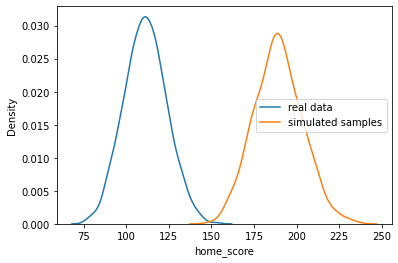

In [49]:
sns.kdeplot(data=inp_data, x='home_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

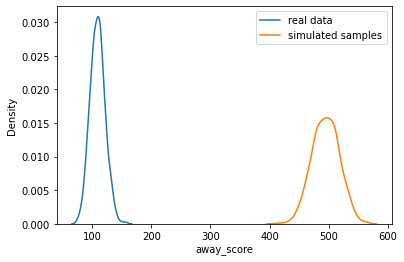

In [50]:
sns.kdeplot(data=inp_data, x='away_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()

## Model 3 - poisson

In [57]:
model_3 = CmdStanModel(stan_file='src/model/model_3.stan')
samples = 1000
sim3=model_3.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=False,
                     refresh=samples)

INFO:cmdstanpy:compiling stan file /app/src/model/model_3.stan to exe file /app/src/model/model_3
INFO:cmdstanpy:compiled model executable: /app/src/model/model_3
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [58]:
mod_3 = sim3.draws_pd()
mod_3.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_att,mu_def,sigma_att,...,log_mu_away[1314],log_mu_away[1315],log_mu_away[1316],log_mu_away[1317],log_mu_away[1318],log_mu_away[1319],log_mu_away[1320],log_mu_away[1321],log_mu_away[1322],log_mu_away[1323]
0,465612.0,0.0,7.84723,0.0,1.0,1.0,-465585.0,-0.715137,-1.46457,1.84133,...,2.20252,1.6683,-2.34797,2.20252,1.11588,1.11588,-1.35485,-1.35485,1.11588,-1.35485
1,465612.0,0.0,7.84723,0.0,1.0,1.0,-465583.0,-0.715137,-1.46457,1.84133,...,2.20252,1.6683,-2.34797,2.20252,1.11588,1.11588,-1.35485,-1.35485,1.11588,-1.35485
2,465612.0,0.0,7.84723,0.0,1.0,1.0,-465585.0,-0.715137,-1.46457,1.84133,...,2.20252,1.6683,-2.34797,2.20252,1.11588,1.11588,-1.35485,-1.35485,1.11588,-1.35485
3,465612.0,0.0,7.84723,0.0,1.0,1.0,-465567.0,-0.715137,-1.46457,1.84133,...,2.20252,1.6683,-2.34797,2.20252,1.11588,1.11588,-1.35485,-1.35485,1.11588,-1.35485
4,465612.0,0.0,7.84723,0.0,1.0,1.0,-465581.0,-0.715137,-1.46457,1.84133,...,2.20252,1.6683,-2.34797,2.20252,1.11588,1.11588,-1.35485,-1.35485,1.11588,-1.35485


In [62]:
seasons_games = {
    pred_year: pd.DataFrame({
        'home_team_id': [0, 1, 2],  # Sample home team IDs
        'away_team_id': [1, 2, 0],  # Sample away team IDs
        'home_score': [100, 95, 110],  # Sample home team scores
        'away_score': [90, 105, 95]   # Sample away team scores
    })
}

# Number of samples for simulation
samples = 1000

# Extracting parameters from the Stan result
parameters = ['attack', 'defense', 'home_advantage']
param_dict = {param: sim3.stan_variable(param) for param in parameters}

# Predicting results for each game
for idx, row in seasons_games[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    
    # Retrieving appropriate parameters for the teams
    home_att = param_dict['attack'][:, home_idx]
    home_def = param_dict['defense'][:, home_idx]
    away_att = param_dict['attack'][:, away_idx]
    away_def = param_dict['defense'][:, away_idx]
    home_advantage = param_dict['home_advantage']
    
    # Creating log_mu parameters
    log_mu1 = home_advantage + home_att - away_def
    log_mu2 = away_att - home_def
    
    # Simulating from Poisson distribution to obtain predictive distribution
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    
    # Blocking draws
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    
    # Calculating outcome probabilities
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [np.mean(y1 > y2)],
        'away_team_win_prob': [np.mean(y1 < y2)]
    })
    
    # Printing results
    print(f"Game {idx + 1}:")
    print(outcome_probabilities)
    print(f"Home Team Points Distribution: {np.mean(y1)} ± {np.std(y1)}")
    print(f"Away Team Points Distribution: {np.mean(y2)} ± {np.std(y2)}\n")

Game 1:
   home_team_win_prob  away_team_win_prob
0                 1.0                 0.0
Home Team Points Distribution: 869.873 ± 29.893793185208196
Away Team Points Distribution: 1.054 ± 1.0252238779895835

Game 2:
   home_team_win_prob  away_team_win_prob
0                 1.0                 0.0
Home Team Points Distribution: 70.019 ± 8.30690309321109
Away Team Points Distribution: 20.973 ± 4.58020425308741

Game 3:
   home_team_win_prob  away_team_win_prob
0                 1.0                 0.0
Home Team Points Distribution: 105.487 ± 10.213414267520927
Away Team Points Distribution: 9.455 ± 2.954653109926781



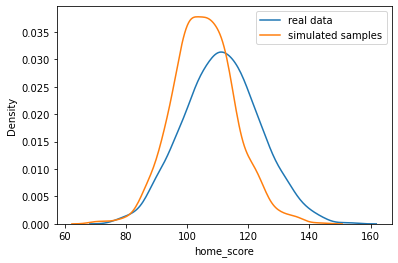

In [66]:
sns.kdeplot(data=inp_data, x='home_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

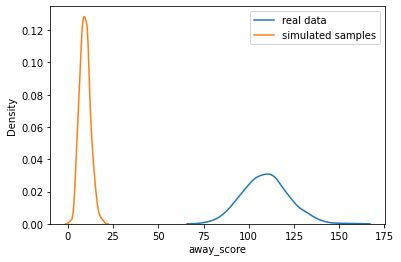

In [67]:
sns.kdeplot(data=inp_data, x='away_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()